## 1. Convolutional Neural Networks
### (a) Loading Dataset

In [19]:
import pytorch_lightning as pl
from torchvision import datasets
from torch.utils.data import DataLoader

train_dataset = datasets.MNIST(root='./hw4-data', # Directory to store the data
                               train=True,
                               download=True
                              )
test_dataset = datasets.MNIST(root='./hw4-data', # Directory to store the data
                              train=False,
                              download=True
                             )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

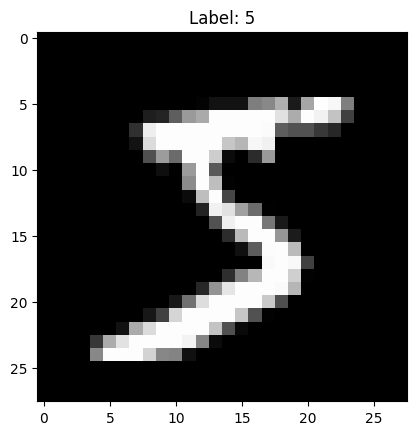

In [20]:
# Visualize an image in this dataset
import matplotlib.pyplot as plt

image, label = train_dataset[0]

# Plot the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

### (b) Preprocessing

In [16]:
from torchvision import datasets , transforms
from torch.utils.data import DataLoader , random_split

transform = transforms.Compose([transforms.ToTensor(), # Converts images to PyTorch tensors
                                transforms.Normalize((0.1307 ,) , (0.3081 ,)) # Normalizes with mean and standard deviation of MNIST
                               ])

train_dataset = datasets.MNIST(root='./hw4-data', # Directory to store the data
                               train=True,
                               download=True,
                               transform=transform
                              )

test_dataset = datasets.MNIST(root='./hw4-data', # Directory to store the data
                              train=False,
                              download=True,
                              transform=transform
                             )

train_size = int (0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size , val_size])
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#print(len(train_subset))
#print(len(val_subset))
#print(len(test_dataset))

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


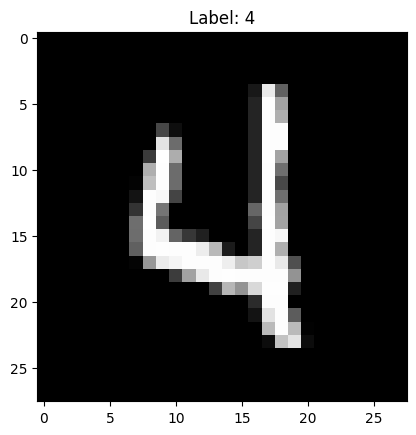

In [6]:
images, labels = next(iter(train_loader))

print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
image = images[0].squeeze()
label = labels[0]

plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

In [7]:
print(images, images.shape)

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

### (c) Implementation

In [8]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import Accuracy

class CNN_1(pl.LightningModule):
    def __init__(self):
        super(CNN_1, self). __init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.fc1 = nn.Linear(32 * 13 * 13, 100)
        self.fc2 = nn.Linear(100, 10)
        self.train_accuracy = Accuracy(task='multiclass', num_classes=10)
        self.val_accuracy = Accuracy(task='multiclass', num_classes=10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        self.train_accuracy.update(y_hat, y)
        loss = nn.CrossEntropyLoss()
        return loss(y_hat, y)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("validation_loss", loss)
        
        preds = torch.argmax(y_hat, dim=1) # Calculate accuracy
        self.val_accuracy.update(preds, y) 
        return {"preds": preds, "y": y}
    
    def on_train_epoch_end(self):
        self.log('train_accuracy', self.train_accuracy.compute())
        self.train_accuracy.reset()

    def on_validation_epoch_end(self):
        self.log("validation_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset() 

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss)

        preds = torch.argmax(y_hat, dim=1) # Calculate accuracy
        accuracy = (preds == y).float().mean()
        self.log('test_accuracy', accuracy)
    
    def configure_optimizers(self):
        return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [9]:
model = CNN_1()
print(model)

CNN_1(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5408, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
)


### (d) Tranining and Evaluating CNN

In [10]:
trainer = pl.Trainer(max_epochs=2, accelerator='gpu' if torch.cuda.is_available() else 'cpu', devices=1)
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 320    | train
1 | pool           | MaxPool2d          | 0      | train
2 | fc1            | Linear             | 540 K  | train
3 | fc2            | Linear             | 1.0 K  | train
4 | train_accuracy | MulticlassAccuracy | 0      | train
5 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
542 K     Trainable params
0         Non-trainable params
542 K     Total params
2.169     Total estimated model params size (MB)
6         Modules in train

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:17<00:00, 99.00it/s, v_num=0]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:15<00:00, 108.95it/s, v_num=0]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:16<00:00, 101.27it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:16<00:00, 101.22it/s, v_num=0]


In [11]:
# Calculate the test_accruracy and test_loss
trainer.test(model, test_loader)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 203.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9835000038146973     │
│         test_loss         │    0.05038272589445114    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.05038272589445114, 'test_accuracy': 0.9835000038146973}]

### (e) Experimenttation
### i. Run the above training for 10 epochs. Plot the validation and training accuracy after every 1 epoch.
#### Please see the attached pdf file for the plot

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger
import os
import shutil

# Remove the previous log files
dir_name = 'tb_logs/hw4_1_e_1/version_1'
if os.path.isdir(dir_name):
    shutil.rmtree(dir_name) 

# Re-generate the dataset and loader
train_subset, val_subset = random_split(train_dataset, [train_size , val_size])
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training
model = CNN_1()
tb_logger = TensorBoardLogger('tb_logs', name='hw4_1_e_1', version="version_1')
trainer = pl.Trainer(max_epochs=10,
                     accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                     devices=1,
                     logger=tb_logger)
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 320    | train
1 | pool           | MaxPool2d          | 0      | train
2 | fc1            | Linear             | 540 K  | train
3 | fc2            | Linear             | 1.0 K  | train
4 | train_accuracy | MulticlassAccuracy | 0      | train
5 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
542 K     Trainable params
0         Non-trainable params
542 K     Total params
2.169     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:16<00:00, 104.69it/s, v_num=on_1]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:15<00:00, 106.98it/s, v_num=on_1]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:17<00:00, 97.67it/s, v_num=on_1]
Validation: |                                                                                                                                    

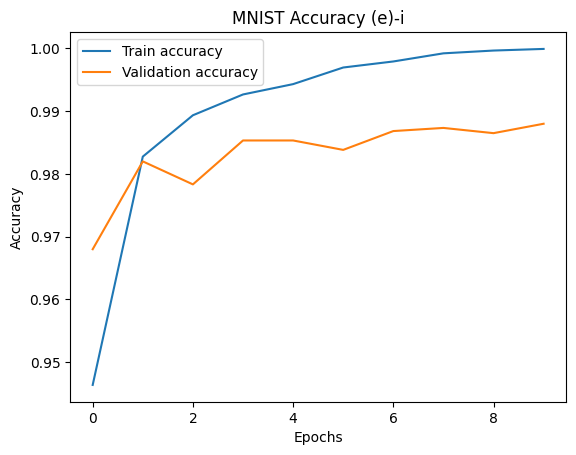

In [22]:
# Plot the training accuracy
import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Read from summary writer
event_acc = EventAccumulator('tb_logs/hw4_1_e_1/version_1')
event_acc.Reload()

# Extract epochs and accuracy values
epochs_e_1 = []
for event in event_acc.Scalars('epoch'):
    if event.value not in epochs_e_1:
        epochs_e_1.append(event.value)
        
train_accuracy_e_1 = [event.value for event in event_acc.Scalars('train_accuracy')]
val_accuracy_e_1 = [event.value for event in event_acc.Scalars('validation_accuracy')]

# Create the plot
plt.plot(epochs_e_1, train_accuracy_e_1, label='Train accuracy')
plt.plot(epochs_e_1, val_accuracy_e_1, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MNIST Accuracy (e)-i')
plt.legend()
plt.savefig('hw4_1_e_1.png')
plt.show()

### ii. Add a 'drop out' layer to avoid overfitting in neural networks
#### Please see the attached pdf file for the plot

In [60]:
class CNN_2(pl.LightningModule):
    def __init__(self):
        super(CNN_2, self). __init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(32 * 13 * 13, 100)
        self.fc2 = nn.Linear(100, 10)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        self.train_accuracy.update(y_hat, y)
        loss = nn.CrossEntropyLoss()
        return loss(y_hat, y)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("validation_loss", loss)
        
        preds = torch.argmax(y_hat, dim=1) # Calculate accuracy
        self.val_accuracy.update(preds, y) 
        return {"preds": preds, "y": y}
    
    def on_train_epoch_end(self):
        self.log('train_accuracy', self.train_accuracy.compute())
        self.train_accuracy.reset()

    def on_validation_epoch_end(self):
        self.log("validation_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset() 

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss)

        preds = torch.argmax(y_hat, dim=1) # Calculate accuracy
        accuracy = (preds == y).float().mean()
        self.log('test_accuracy', accuracy)
    
    def configure_optimizers(self):
        return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [61]:
# Remove the previous log files
dir_name = 'tb_logs/hw4_1_e_2/version_1'
if os.path.isdir(dir_name):
    shutil.rmtree(dir_name) 

# Re-generate the dataset and loader
train_subset, val_subset = random_split(train_dataset, [train_size , val_size])
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training
model = CNN_2()
tb_logger = TensorBoardLogger('tb_logs', name='hw4_1_e_2', version="version_1")
trainer = pl.Trainer(max_epochs=10,
                     accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                     devices=1,
                     logger=tb_logger)
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 320    | train
1 | pool           | MaxPool2d          | 0      | train
2 | dropout        | Dropout            | 0      | train
3 | fc1            | Linear             | 540 K  | train
4 | fc2            | Linear             | 1.0 K  | train
5 | train_accuracy | MulticlassAccuracy | 0      | train
6 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
542 K     Trainable params
0         Non-trainable params
542 K     Total params
2.169     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:16<00:00, 103.82it/s, v_num=on_1]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:18<00:00, 93.67it/s, v_num=on_1]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:18<00:00, 93.22it/s, v_num=on_1]
Validation: |                                                                                                                                    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:19<00:00, 86.93it/s, v_num=on_1]


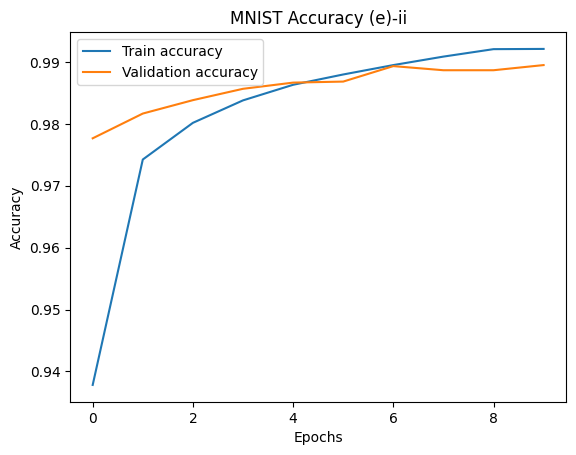

In [23]:
# Read from summary writer
event_acc = EventAccumulator('tb_logs/hw4_1_e_2/version_1')
event_acc.Reload()

# Extract epochs and accuracy values
epochs_e_2 = []
for event in event_acc.Scalars('epoch'):
    if event.value not in epochs_e_2:
        epochs_e_2.append(event.value)
        
train_accuracy_e_2 = [event.value for event in event_acc.Scalars('train_accuracy')]
val_accuracy_e_2 = [event.value for event in event_acc.Scalars('validation_accuracy')]

# Create the plot
plt.plot(epochs_e_2, train_accuracy_e_2, label='Train accuracy')
plt.plot(epochs_e_2, val_accuracy_e_2, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MNIST Accuracy (e)-ii')
plt.legend()
plt.savefig('hw4_1_e_2.png')
plt.show()

### iii. Add another convolution layer and maxpooling layer to the CNN model defined above (immediately following the existing maxpooling layer)
#### Please see the attached pdf file for the plot

In [73]:
class CNN_3(pl.LightningModule):
    def __init__(self):
        super(CNN_3, self). __init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, 10)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        self.train_accuracy.update(y_hat, y)
        loss = nn.CrossEntropyLoss()
        return loss(y_hat, y)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("validation_loss", loss)
        
        preds = torch.argmax(y_hat, dim=1) # Calculate accuracy
        self.val_accuracy.update(preds, y) 
        return {"preds": preds, "y": y}
    
    def on_train_epoch_end(self):
        self.log('train_accuracy', self.train_accuracy.compute())
        self.train_accuracy.reset()

    def on_validation_epoch_end(self):
        self.log("validation_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset() 

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss)

        preds = torch.argmax(y_hat, dim=1) # Calculate accuracy
        accuracy = (preds == y).float().mean()
        self.log('test_accuracy', accuracy)
    
    def configure_optimizers(self):
        return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [74]:
# Remove the previous log files
dir_name = 'tb_logs/hw4_1_e_3/version_1'
if os.path.isdir(dir_name):
    shutil.rmtree(dir_name) 

# Re-generate the dataset and loader
train_subset, val_subset = random_split(train_dataset, [train_size , val_size])
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training
model = CNN_3()
tb_logger = TensorBoardLogger('tb_logs', name='hw4_1_e_3', version="version_1")
trainer = pl.Trainer(max_epochs=10,
                     accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                     devices=1,
                     logger=tb_logger)
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 320    | train
1 | pool1          | MaxPool2d          | 0      | train
2 | conv2          | Conv2d             | 18.5 K | train
3 | pool2          | MaxPool2d          | 0      | train
4 | dropout        | Dropout            | 0      | train
5 | fc1            | Linear             | 160 K  | train
6 | fc2            | Linear             | 1.0 K  | train
7 | train_accuracy | MulticlassAccuracy | 0      | train
8 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
179 K     Trainable params
0         Non-trainable params
179 K     Total params
0.720     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval

Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:23<00:00, 72.48it/s, v_num=on_1]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:26<00:00, 63.52it/s, v_num=on_1]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:25<00:00, 67.30it/s, v_num=on_1]
Validation: |                                                                                                                                    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:24<00:00, 70.05it/s, v_num=on_1]


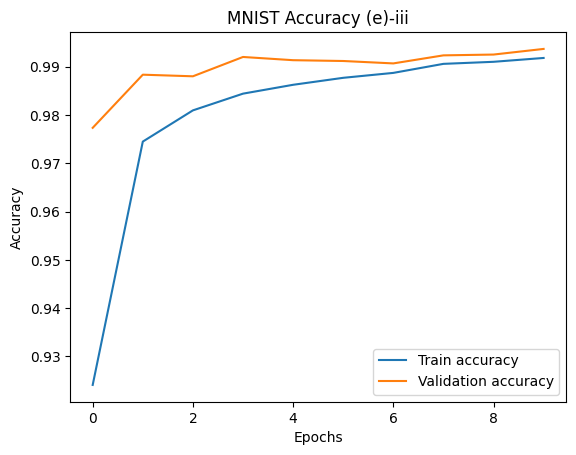

In [24]:
# Read from summary writer
event_acc = EventAccumulator('tb_logs/hw4_1_e_3/version_1')
event_acc.Reload()

# Extract epochs and accuracy values
epochs_e_3 = []
for event in event_acc.Scalars('epoch'):
    if event.value not in epochs_e_3:
        epochs_e_3.append(event.value)
        
train_accuracy_e_3 = [event.value for event in event_acc.Scalars('train_accuracy')]
val_accuracy_e_3 = [event.value for event in event_acc.Scalars('validation_accuracy')]

# Create the plot
plt.plot(epochs_e_3, train_accuracy_e_3, label='Train accuracy')
plt.plot(epochs_e_3, val_accuracy_e_3, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MNIST Accuracy (e)-iii')
plt.legend()
plt.savefig('hw4_1_e_3.png')
plt.show()

### iv. Use learning rates of 0.03 and 0.003 respectively to train the model
### Case 1) lr = 0.03
#### Please see the attached pdf file for the plot

In [77]:
class CNN_4a(pl.LightningModule):
    def __init__(self):
        super(CNN_4a, self). __init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, 10)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        self.train_accuracy.update(y_hat, y)
        loss = nn.CrossEntropyLoss()
        return loss(y_hat, y)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("validation_loss", loss)
        
        preds = torch.argmax(y_hat, dim=1) # Calculate accuracy
        self.val_accuracy.update(preds, y) 
        return {"preds": preds, "y": y}
    
    def on_train_epoch_end(self):
        self.log('train_accuracy', self.train_accuracy.compute())
        self.train_accuracy.reset()

    def on_validation_epoch_end(self):
        self.log("validation_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset() 

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss)

        preds = torch.argmax(y_hat, dim=1) # Calculate accuracy
        accuracy = (preds == y).float().mean()
        self.log('test_accuracy', accuracy)
    
    def configure_optimizers(self):
        return optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

In [78]:
# Remove the previous log files
dir_name = 'tb_logs/hw4_1_e_4a/version_1'
if os.path.isdir(dir_name):
    shutil.rmtree(dir_name) 

# Re-generate the dataset and loader
train_subset, val_subset = random_split(train_dataset, [train_size , val_size])
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training
model = CNN_4a()
tb_logger = TensorBoardLogger('tb_logs', name='hw4_1_e_4a', version="version_1")
trainer = pl.Trainer(max_epochs=10,
                     accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                     devices=1,
                     logger=tb_logger)
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 320    | train
1 | pool1          | MaxPool2d          | 0      | train
2 | conv2          | Conv2d             | 18.5 K | train
3 | pool2          | MaxPool2d          | 0      | train
4 | dropout        | Dropout            | 0      | train
5 | fc1            | Linear             | 160 K  | train
6 | fc2            | Linear             | 1.0 K  | train
7 | train_accuracy | MulticlassAccuracy | 0      | train
8 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
179 K     Trainable params
0         Non-trainable params
179 K     Total params
0.720     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval

Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:22<00:00, 75.90it/s, v_num=on_1]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:24<00:00, 67.74it/s, v_num=on_1]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:24<00:00, 69.48it/s, v_num=on_1]
Validation: |                                                                                                                                    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:25<00:00, 66.33it/s, v_num=on_1]


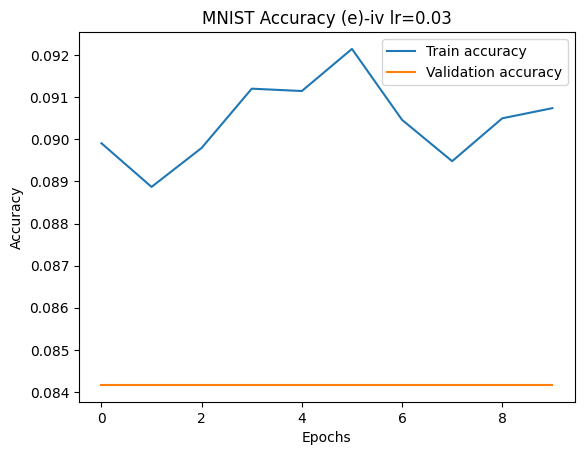

In [25]:
# Read from summary writer
event_acc = EventAccumulator('tb_logs/hw4_1_e_4a/version_1')
event_acc.Reload()

# Extract epochs and accuracy values
epochs_e_4a = []
for event in event_acc.Scalars('epoch'):
    if event.value not in epochs_e_4a:
        epochs_e_4a.append(event.value)
        
train_accuracy_e_4a = [event.value for event in event_acc.Scalars('train_accuracy')]
val_accuracy_e_4a = [event.value for event in event_acc.Scalars('validation_accuracy')]

# Create the plot
plt.plot(epochs_e_4a, train_accuracy_e_4a, label='Train accuracy')
plt.plot(epochs_e_4a, val_accuracy_e_4a, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MNIST Accuracy (e)-iv lr=0.03')
plt.legend()
plt.savefig('hw4_1_e_4a.png')
plt.show()

### iv. Use learning rates of 0.03 and 0.003 respectively to train the model
### Case 2) lr = 0.003
#### Please see the attached pdf file for the plot

In [80]:
class CNN_4b(pl.LightningModule):
    def __init__(self):
        super(CNN_4b, self). __init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, 10)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        self.train_accuracy.update(y_hat, y)
        loss = nn.CrossEntropyLoss()
        return loss(y_hat, y)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("validation_loss", loss)
        
        preds = torch.argmax(y_hat, dim=1) # Calculate accuracy
        self.val_accuracy.update(preds, y) 
        return {"preds": preds, "y": y}
    
    def on_train_epoch_end(self):
        self.log('train_accuracy', self.train_accuracy.compute())
        self.train_accuracy.reset()

    def on_validation_epoch_end(self):
        self.log("validation_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset() 

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss)

        preds = torch.argmax(y_hat, dim=1) # Calculate accuracy
        accuracy = (preds == y).float().mean()
        self.log('test_accuracy', accuracy)
    
    def configure_optimizers(self):
        return optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

In [81]:
# Remove the previous log files
dir_name = 'tb_logs/hw4_1_e_4b/version_1'
if os.path.isdir(dir_name):
    shutil.rmtree(dir_name) 

# Re-generate the dataset and loader
train_subset, val_subset = random_split(train_dataset, [train_size , val_size])
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training
model = CNN_4b()
tb_logger = TensorBoardLogger('tb_logs', name='hw4_1_e_4b', version="version_1")
trainer = pl.Trainer(max_epochs=10,
                     accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                     devices=1,
                     logger=tb_logger)
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 320    | train
1 | pool1          | MaxPool2d          | 0      | train
2 | conv2          | Conv2d             | 18.5 K | train
3 | pool2          | MaxPool2d          | 0      | train
4 | dropout        | Dropout            | 0      | train
5 | fc1            | Linear             | 160 K  | train
6 | fc2            | Linear             | 1.0 K  | train
7 | train_accuracy | MulticlassAccuracy | 0      | train
8 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
179 K     Trainable params
0         Non-trainable params
179 K     Total params
0.720     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval

Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:21<00:00, 79.06it/s, v_num=on_1]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:25<00:00, 66.70it/s, v_num=on_1]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:23<00:00, 71.08it/s, v_num=on_1]
Validation: |                                                                                                                                    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [00:25<00:00, 66.35it/s, v_num=on_1]


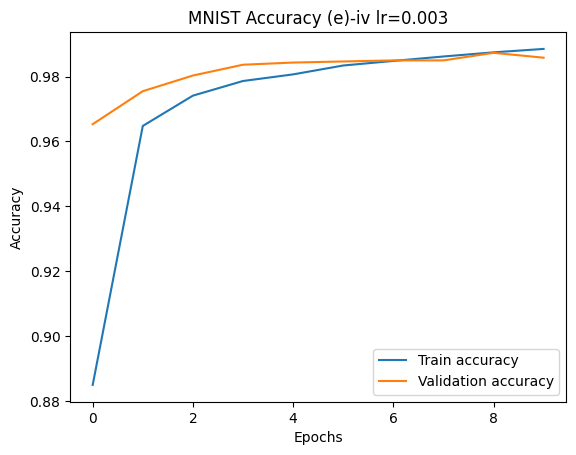

In [26]:
# Read from summary writer
event_acc = EventAccumulator('tb_logs/hw4_1_e_4b/version_1')
event_acc.Reload()

# Extract epochs and accuracy values
epochs_e_4b = []
for event in event_acc.Scalars('epoch'):
    if event.value not in epochs_e_4b:
        epochs_e_4b.append(event.value)
        
train_accuracy_e_4b = [event.value for event in event_acc.Scalars('train_accuracy')]
val_accuracy_e_4b = [event.value for event in event_acc.Scalars('validation_accuracy')]

# Create the plot
plt.plot(epochs_e_4b, train_accuracy_e_4b, label='Train accuracy')
plt.plot(epochs_e_4b, val_accuracy_e_4b, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MNIST Accuracy (e)-iv lr=0.003')
plt.legend()
plt.savefig('hw4_1_e_4b.png')
plt.show()

### f. Analysis
#### Please see the attached pdf file for the plots and detailed analysis

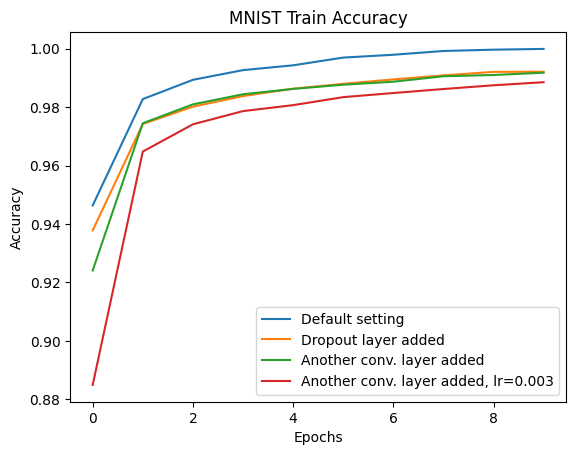

In [28]:
# Create the train accuracy plot
plt.plot(epochs_e_1, train_accuracy_e_1, label='Default setting')
plt.plot(epochs_e_1, train_accuracy_e_2, label='Dropout layer added')
plt.plot(epochs_e_1, train_accuracy_e_3, label='Another conv. layer added')
plt.plot(epochs_e_1, train_accuracy_e_4b, label='Another conv. layer added, lr=0.003')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MNIST Train Accuracy')
plt.legend()
plt.savefig('hw4_1_f_train.png')
plt.show()

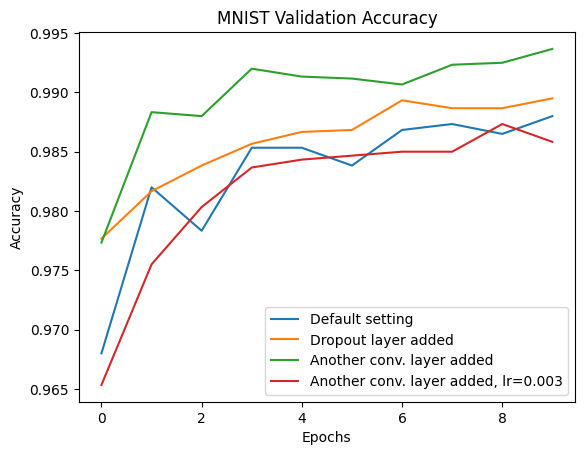

In [29]:
# Create the validation accuracy plot
plt.plot(epochs_e_1, val_accuracy_e_1, label='Default setting')
plt.plot(epochs_e_1, val_accuracy_e_2, label='Dropout layer added')
plt.plot(epochs_e_1, val_accuracy_e_3, label='Another conv. layer added')
plt.plot(epochs_e_1, val_accuracy_e_4b, label='Another conv. layer added, lr=0.003')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MNIST Validation Accuracy')
plt.legend()
plt.savefig('hw4_1_f_val.png')
plt.show()